In [7]:
import os
import sys

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.base import clone
from sklearn.decomposition import PCA
from mlxtend.feature_selection import ColumnSelector

PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), '../'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
    
from server.ml_models import EnsembleModel
from server.ml_models.all_model import AllModelData
from src.model.metrics import measure_estimators, yearly_performance_scores
from src.model.charts import graph_cv_model_performance, graph_yearly_model_performance
from server.ml_models.data_config import TEAM_NAMES, ROUND_TYPES

np.random.seed(42)

N_ITER = 5
SCORING = 'neg_mean_absolute_error'
CV = 5

In [2]:
data = AllModelData(train_years=(None, 2015), test_years=(2016, 2016))

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


### Baseline bagging model with XGB

In [3]:
bag_model = EnsembleModel()
bag_score = cross_val_score(bag_model, *data.train_data(), scoring=SCORING, cv=CV, n_jobs=-1)
bag_score

array([-26.16858251, -25.80469955, -27.1914056 , -26.47905796,
       -27.06154325])

In [4]:
bag_score.mean()

-26.54105777403654

## Feature selection

### Feature selection with correlation to labels

In [18]:
X_train, y_train = data.train_data()
X_train['margin'] = y_train

X_train.corr()['margin'].abs().sort_values(ascending=False)

margin                                             1.000000
oppo_rolling_last_week_win_rate                    0.327654
rolling_last_week_win_rate                         0.327282
ladder_position                                    0.253778
oppo_win_streak                                    0.217786
win_streak                                         0.217642
line_odds                                          0.216245
oppo_line_odds                                     0.216245
at_home                                            0.213125
oppo_cum_win_points                                0.171706
cum_win_points                                     0.170927
oppo_last_week_result                              0.144011
last_week_result                                   0.143821
win_odds                                           0.126010
oppo_win_odds                                      0.125942
oppo_last_week_score                               0.108902
last_week_score                         

In [34]:
from sklearn.base import TransformerMixin, BaseEstimator, clone


class CorrelationChooser(TransformerMixin, BaseEstimator):
    def __init__(self, response, cols_to_keep=[], threshold=None):
        self.response = response
        self.threshold = threshold
        self.cols_to_keep = cols_to_keep
        self._cols_to_keep = self.cols_to_keep

    def transform(self, X):
        return X[self._cols_to_keep]

    def fit(self, X, *_):
        df = pd.concat([X, self.response], axis=1).drop(self.cols_to_keep, axis=1)
        self._cols_to_keep = df.columns[df.corr()[df.columns[-1]].abs() > self.threshold]
        self._cols_to_keep = self.cols_to_keep + [c for c in self._cols_to_keep if c in X.columns]

        return self

_, y_train = data.train_data()
bag_model2 = clone(bag_model)
bag_model2.pipeline.steps = [
    (
        "correlationchooser",
        CorrelationChooser(
            y_train,
            threshold=0.1,
            cols_to_keep=["team", "oppo_team", "round_type"],
        ),
    )
] + bag_model2.pipeline.steps


bag_params = {
    'pipeline__baggingregressor__n_estimators': stats.randint(5, 15),
    'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'],
    'pipeline__baggingregressor__base_estimator__colsample_bylevel': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__colsample_bytree': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__learning_rate': stats.uniform(0.075, 0.05),
    'pipeline__baggingregressor__base_estimator__max_depth': stats.randint(2, 10),
    'pipeline__baggingregressor__base_estimator__n_estimators': stats.randint(75, 150),
    'pipeline__baggingregressor__base_estimator__reg_alpha': stats.uniform(0.0, 0.2),
    'pipeline__baggingregressor__base_estimator__reg_lambda': stats.uniform(0.75, 0.5),
    'pipeline__baggingregressor__base_estimator__subsample': stats.uniform(0.8, 0.2),
    'pipeline__correlationchooser__threshold': stats.uniform(0.0, 0.2)
}

bag_cv = RandomizedSearchCV(bag_model2, bag_params, scoring=SCORING, n_jobs=-1,
                            cv=CV, n_iter=N_ITER)

In [35]:
bag_cv.fit(*data.train_data())

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=EnsembleModel(name='EnsembleModel',
       pipeline=Pipeline(memory=None,
     steps=[('correlationchooser', CorrelationChooser(cols_to_keep=['team', 'oppo_team', 'round_type'],
          response=Adelaide          1991  1.0      86
                        2.0     -23
                        3.0      24
                        4.0     -45
                        5.0     -65
  ...imators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'pipeline__baggingregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff0d164a828>, 'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'], 'pipeline__baggingregressor__base_estimator__colsample_bylevel': <scipy.stat...relationchooser__threshold': <scipy.stats._distn_infrastructure

In [36]:
bag_cv.best_score_, bag_cv.best_params_

(-26.81892204907551,
 {'pipeline__baggingregressor__base_estimator__booster': 'gbtree',
  'pipeline__baggingregressor__base_estimator__colsample_bylevel': 0.9677867004138727,
  'pipeline__baggingregressor__base_estimator__colsample_bytree': 0.9720809236623351,
  'pipeline__baggingregressor__base_estimator__learning_rate': 0.0875125680257932,
  'pipeline__baggingregressor__base_estimator__max_depth': 3,
  'pipeline__baggingregressor__base_estimator__n_estimators': 144,
  'pipeline__baggingregressor__base_estimator__reg_alpha': 0.06065310293464457,
  'pipeline__baggingregressor__base_estimator__reg_lambda': 1.0185412135983278,
  'pipeline__baggingregressor__base_estimator__subsample': 0.8653302483592082,
  'pipeline__baggingregressor__n_estimators': 12,
  'pipeline__correlationchooser__threshold': 0.15399871061972217})

### Feature selection with p-values

In [58]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge

ridge = Ridge()
X_train, y_train = data.train_data()
ridge.fit(pd.get_dummies(X_train), y_train)

sorted(abs(ridge.coef_), reverse=True)

[37.806523035106224,
 36.913854852575085,
 18.99903201849101,
 15.504556232321054,
 10.226574277517356,
 8.99455795602965,
 8.508626257686167,
 7.371962377430895,
 6.027224980570031,
 5.72578444301597,
 5.541278499735153,
 4.995320765789591,
 4.815490702259002,
 4.462484554650309,
 4.326303549644608,
 4.292698481233432,
 4.123963666517359,
 3.4005860838661306,
 3.3297152587943457,
 3.027407299925849,
 2.9720305688362307,
 2.782993446208077,
 2.683708132851588,
 2.668553976079636,
 2.495500737634787,
 2.404050376278933,
 2.2883484828052354,
 2.0368050080329456,
 2.0313510490243405,
 1.9313371257290566,
 1.8385206573974324,
 1.5200580433456823,
 1.3047036039800903,
 1.2420240799311337,
 1.2188895985051476,
 1.067672702764235,
 0.9293721727038888,
 0.8835297148678186,
 0.8318529724419396,
 0.8143978018763713,
 0.7511401425695406,
 0.733518007269416,
 0.5932457783681232,
 0.5886178214812834,
 0.5478916940603383,
 0.5244264977281017,
 0.5228862429177966,
 0.4758548448957521,
 0.440421505815

In [68]:
bag_model3 = clone(bag_model)
bag_model3.pipeline.steps = [bag_model3.pipeline.steps[0]] + [
    (
        "selectfrommodel",
        SelectFromModel(Ridge(), threshold=0.5)
    )
] + bag_model3.pipeline.steps[1:]


bag_params3 = {
    'pipeline__baggingregressor__n_estimators': stats.randint(5, 15),
    'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'],
    'pipeline__baggingregressor__base_estimator__colsample_bylevel': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__colsample_bytree': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__learning_rate': stats.uniform(0.075, 0.05),
    'pipeline__baggingregressor__base_estimator__max_depth': stats.randint(2, 10),
    'pipeline__baggingregressor__base_estimator__n_estimators': stats.randint(75, 150),
    'pipeline__baggingregressor__base_estimator__reg_alpha': stats.uniform(0.0, 0.2),
    'pipeline__baggingregressor__base_estimator__reg_lambda': stats.uniform(0.75, 0.5),
    'pipeline__baggingregressor__base_estimator__subsample': stats.uniform(0.8, 0.2),
    'pipeline__selectfrommodel__threshold': ['median', 'mean', 0.01, 0.05, 0.1],
    'pipeline__selectfrommodel__estimator__alpha': stats.uniform(0.75, 0.5),
    'pipeline__selectfrommodel__estimator__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
}

bag_cv3 = RandomizedSearchCV(bag_model3, bag_params3, scoring=SCORING, n_jobs=-1,
                            cv=CV, n_iter=N_ITER)

In [69]:
bag_cv3.fit(*data.train_data())

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=EnsembleModel(name='EnsembleModel',
       pipeline=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None,
       categories=[['Adelaide', 'Brisbane', 'Carlton', 'Collingwood', 'Essen...imators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'pipeline__baggingregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff071d147f0>, 'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'], 'pipeline__baggingregressor__base_estimator__colsample_bylevel': <scipy.stat...electfrommodel__estimator__solver': ['auto', 'svd', 'cholesky',

In [71]:
bag_cv3.best_score_, bag_cv3.best_params_

(-26.801925913966823,
 {'pipeline__baggingregressor__base_estimator__booster': 'gbtree',
  'pipeline__baggingregressor__base_estimator__colsample_bylevel': 0.8554762365962266,
  'pipeline__baggingregressor__base_estimator__colsample_bytree': 0.8376242319447523,
  'pipeline__baggingregressor__base_estimator__learning_rate': 0.09818492024699911,
  'pipeline__baggingregressor__base_estimator__max_depth': 3,
  'pipeline__baggingregressor__base_estimator__n_estimators': 134,
  'pipeline__baggingregressor__base_estimator__reg_alpha': 0.11673122237017441,
  'pipeline__baggingregressor__base_estimator__reg_lambda': 0.7888673184824924,
  'pipeline__baggingregressor__base_estimator__subsample': 0.9948789615332334,
  'pipeline__baggingregressor__n_estimators': 10,
  'pipeline__selectfrommodel__estimator__alpha': 0.7661579755548252,
  'pipeline__selectfrommodel__estimator__solver': 'auto',
  'pipeline__selectfrommodel__threshold': 'median'})

### Bagging XGB without extra feature selection is better
Given that XGB has its own built-in feature selection probably makes adding a feature selection step to the pipeline superfluous.

## Dimension reduction

### PCA

In [56]:
X_train, _ = data.train_data()

pca = PCA()
pca.fit_transform(pd.get_dummies(X_train))
np.cumsum(pca.explained_variance_ratio_)

array([0.52156993, 0.92467793, 0.99702563, 0.99914274, 0.9995079 ,
       0.99960309, 0.99968507, 0.99976493, 0.99982684, 0.99987036,
       0.99989177, 0.99991088, 0.99992471, 0.99993472, 0.99994399,
       0.99995147, 0.99995865, 0.99996427, 0.99996964, 0.99997483,
       0.99997858, 0.99998206, 0.99998435, 0.99998615, 0.99998769,
       0.99998911, 0.99999043, 0.99999172, 0.99999275, 0.99999359,
       0.9999944 , 0.99999512, 0.99999573, 0.99999615, 0.99999651,
       0.99999684, 0.99999713, 0.9999974 , 0.99999766, 0.9999979 ,
       0.99999812, 0.99999833, 0.99999852, 0.99999871, 0.99999886,
       0.99999901, 0.99999914, 0.99999925, 0.99999936, 0.99999945,
       0.99999952, 0.99999958, 0.99999963, 0.99999967, 0.99999971,
       0.99999974, 0.99999976, 0.99999978, 0.99999979, 0.99999981,
       0.99999982, 0.99999983, 0.99999984, 0.99999985, 0.99999985,
       0.99999986, 0.99999987, 0.99999988, 0.99999988, 0.99999989,
       0.9999999 , 0.9999999 , 0.99999991, 0.99999992, 0.99999

Text(0, 0.5, '% of Variance Explained < = k')

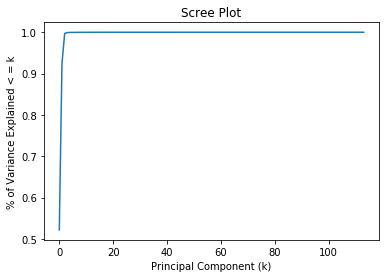

In [57]:
%matplotlib

import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Scree Plot')
plt.xlabel('Principal Component (k)')
plt.ylabel('% of Variance Explained < = k')


### Top 3 components explain 99% of variance

In [58]:
n_features = len(data.train_data()[0].columns)

bag_model4 = clone(bag_model)
bag_model4.pipeline.steps = [
    (
        'columntransformer',
         ColumnTransformer(
            [
                (
                    "onehotencoder",
                    OneHotEncoder(
                        categories=[TEAM_NAMES, TEAM_NAMES, ROUND_TYPES], sparse=False
                    ),
                    list(range(3)),
                ),
                (
                    'pca',
                    PCA(),
                    list(range(3, n_features)),
                )
            ],
            remainder="passthrough",
        ),
    ),
] + bag_model4.pipeline.steps[1:]


bag_params4 = {
    'pipeline__baggingregressor__n_estimators': stats.randint(5, 15),
    'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'],
    'pipeline__baggingregressor__base_estimator__colsample_bylevel': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__colsample_bytree': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__learning_rate': stats.uniform(0.075, 0.05),
    'pipeline__baggingregressor__base_estimator__max_depth': stats.randint(2, 10),
    'pipeline__baggingregressor__base_estimator__n_estimators': stats.randint(75, 150),
    'pipeline__baggingregressor__base_estimator__reg_alpha': stats.uniform(0.0, 0.2),
    'pipeline__baggingregressor__base_estimator__reg_lambda': stats.uniform(0.75, 0.5),
    'pipeline__baggingregressor__base_estimator__subsample': stats.uniform(0.8, 0.2),
    'pipeline__columntransformer__pca__n_components': stats.randint(3, 10),
}

bag_cv4 = RandomizedSearchCV(bag_model4, bag_params4, scoring=SCORING, n_jobs=-1,
                            cv=CV, n_iter=N_ITER)

In [59]:
bag_cv4.fit(*data.train_data())

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=EnsembleModel(name='EnsembleModel',
       pipeline=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None,
       categories=[['Adelaide', 'Brisbane', 'Carlton', 'Collingwood', 'Essen...imators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'pipeline__baggingregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fae49fe95f8>, 'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'], 'pipeline__baggingregressor__base_estimator__colsample_bylevel': <scipy.stat...sformer__pca__n_components': <scipy.stats._distn_infrastructure

In [60]:
bag_cv4.best_score_, bag_cv4.best_params_

(-30.323303305148656,
 {'pipeline__baggingregressor__base_estimator__booster': 'dart',
  'pipeline__baggingregressor__base_estimator__colsample_bylevel': 0.9978250638217467,
  'pipeline__baggingregressor__base_estimator__colsample_bytree': 0.8530094574818567,
  'pipeline__baggingregressor__base_estimator__learning_rate': 0.10860297513308677,
  'pipeline__baggingregressor__base_estimator__max_depth': 4,
  'pipeline__baggingregressor__base_estimator__n_estimators': 104,
  'pipeline__baggingregressor__base_estimator__reg_alpha': 0.022729207739343883,
  'pipeline__baggingregressor__base_estimator__reg_lambda': 0.7519591874755467,
  'pipeline__baggingregressor__base_estimator__subsample': 0.9998921362119346,
  'pipeline__baggingregressor__n_estimators': 5,
  'pipeline__columntransformer__pca__n_components': 9})

### PCA doesn't seem to improve performance
An earlier run had 42 for n_components, but still got an error score a full point worse than the model without any feature reduction.